In [47]:
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import seaborn as sns

In [48]:
#import data:

adata = sc.read_h5ad("X:/talbarka/cfRNA/cfRNA_joint_data/01-PC_anndata.h5ad")
adata.X = adata.layers['mat_norm']
adata.layers['mat_norm']

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.18934348e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.41676604e-05, ...,
        0.00000000e+00, 4.41676604e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.75507876e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.05059950e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.71047680e-05, ...,
        8.48108982e-05, 0.00000000e+00, 0.00000000e+00]])

In [49]:
#import the fat marker genes:
adipose_visceral = pd.read_csv("X:/avital/cfRNA_vs_GTEx_FAT/adipose_visceral", index_col="Description")
adipose_subcutaneous = pd.read_csv("X:/avital/cfRNA_vs_GTEx_FAT/adipose_subcutaneous", index_col="Description")

In [50]:
adipose_visceral.columns = [""]
adipose_subcutaneous.columns = [""]

In [51]:
combined_df_fat_gtex = pd.merge(adipose_visceral, adipose_subcutaneous, on='Description', how='outer') #combine 2 df
combined_df_fat_gtex[''] = combined_df_fat_gtex[['_x', '_y']].max(axis=1) #calculate the min fc of the 2 options
combined_df_fat_gtex.drop(columns=['_x', '_y'], inplace=True)


In [52]:
#both adipose_subcutaneous and adipose_visceral in a dataframe with exp level:
combined_df_fat_gtex
#the above in a list - only markers names:
lst_of_fat_genes = list(combined_df_fat_gtex.index)

In [53]:
#dataframe of all genes in all samples of cfRNA, specifically of mat_norm layer (normalized to UMI's):
adata_to_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names).T
adata_to_df
#above dataframe after filtering for the fat markers from GTEx:
df_filterd_for_fat = adata_to_df[adata_to_df.index.isin(lst_of_fat_genes)]   #50
#list of the above markers:
lst_df_filterd_for_fat = list(df_filterd_for_fat.index)



In [54]:
#all markers from GTEx after filtering for those who are adata - cfRNA:
combined_df_fat_gtex_filtered = combined_df_fat_gtex[combined_df_fat_gtex.index.isin(lst_df_filterd_for_fat)]
#indexes are the gene name, and first column is the FC: 
combined_df_fat_gtex_filtered.columns=["FC"]
combined_df_fat_gtex_filtered.index.rename(name="gene_name",inplace=True)


Text(0.5, 1.0, 'Spearman Correlation vs. FC threshold')

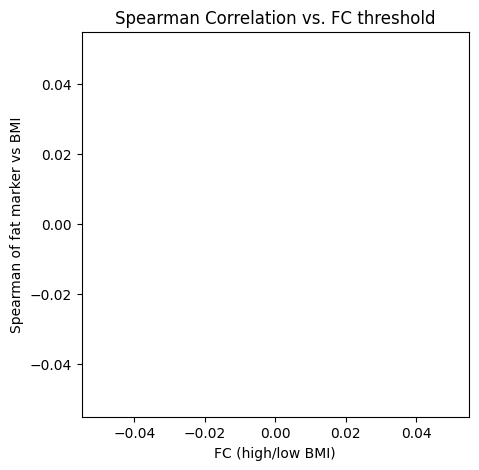

In [55]:
#loop over the fat dataframe to find those that are above a foldchange (fc) threshold:
threshold_range = list(range(2,2))
spearman_correlations = []

for fc in threshold_range:
    #find the fat marker above fc from GTEx in adata(matnorm and filtered)
    subset_combined_df_fat_gtex_filtered = combined_df_fat_gtex_filtered[combined_df_fat_gtex_filtered["FC"]>fc]
    lst_subset_combined_df_fat_gtex_filtered = list(subset_combined_df_fat_gtex_filtered.index)
    subset_df_filterd_for_fat = df_filterd_for_fat[df_filterd_for_fat.index.isin(lst_subset_combined_df_fat_gtex_filtered)]
    df_filterd_for_fat.drop(columns=["CF6_cfRNA1", "CF8_cfRNA1"])
    subset_df_filterd_for_fat.drop(columns=["CF6_cfRNA1", "CF8_cfRNA1"])

    #sum the exp level for the filtered adata after the fc filter
    sum_fat = subset_df_filterd_for_fat.sum(axis=0)
    sum_fat = pd.DataFrame(sum_fat).T
    sum_fat.index = ["FAT_MARKER"]
    only_low_bmi = sum_fat.drop(columns=["CF6_cfRNA1", "CF8_cfRNA1"])
    
    #add the BMI values of patients:
    bmi_values = [23.4, 21.7, 21.7, 28.1, 21.8, 26]
    only_low_bmi.loc["BMI"] = bmi_values
    fat_bmi = only_low_bmi.sort_values(by='BMI', axis=1, ascending=True)

   #plot a scatter graph:
    plt.figure(figsize=(5, 5))
    plt.scatter(fat_bmi.loc['BMI'], fat_bmi.loc['FAT_MARKER'])

    spearman_corr,  p_value = spearmanr(fat_bmi.loc['BMI'], fat_bmi.loc['FAT_MARKER'])
    plt.text(1.05, 0.5, f'Spearman Correlation: {spearman_corr:.2f}\nP-value: {p_value:.2f}', transform=plt.gca().transAxes, ha='left')

    for sample, bmi, fat in zip(fat_bmi.columns, fat_bmi.loc['BMI'], fat_bmi.loc['FAT_MARKER']):
        plt.text(bmi, fat, sample, fontsize=8, ha='left', va='bottom')

    plt.xlabel('BMI')
    plt.ylabel('FAT Gene Expression')
    plt.title(f"correlation of BMI vs FAT markers, FC = {fc}")
    plt.grid(True)

    spearman_correlations.append(spearman_corr)

#figure of Spearman Correlation vs. Fold Change:
plt.figure(figsize=(5, 5))
plt.plot(threshold_range ,spearman_correlations, marker='o', linestyle='-')
plt.xlabel('FC (high/low BMI)')
plt.ylabel('Spearman of fat marker vs BMI')
plt.title('Spearman Correlation vs. FC threshold')
   
    

Text(0.5, 1.0, 'Spearman Correlation vs. FC threshold')

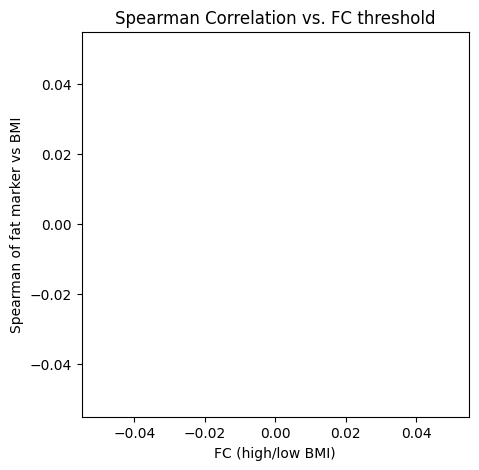

In [56]:
#loop over the fat dataframe to find those that are above a foldchange (fc) threshold:
threshold_range = list(range(2,2))
spearman_correlations = []

for fc in threshold_range:
    #find the fat marker above fc from GTEx in adata(matnorm and filtered)
    subset_combined_df_fat_gtex_filtered = combined_df_fat_gtex_filtered[combined_df_fat_gtex_filtered["FC"]>fc]
    lst_subset_combined_df_fat_gtex_filtered = list(subset_combined_df_fat_gtex_filtered.index)
    subset_df_filterd_for_fat = df_filterd_for_fat[df_filterd_for_fat.index.isin(lst_subset_combined_df_fat_gtex_filtered)]
    
    #sum the exp level for the filtered adata after the fc filter
    sum_fat = subset_df_filterd_for_fat.sum(axis=0)
    sum_fat = pd.DataFrame(sum_fat).T
    sum_fat.index = ["FAT_MARKER"]

    #add the BMI values of patients:
    bmi_values = [23.4, 21.7, 21.7, 28.1, 21.8, 36.2, 26, 33.5]
    sum_fat.loc["BMI"] = bmi_values
    fat_bmi = sum_fat.sort_values(by='BMI', axis=1, ascending=True)

    #plot a scatter graph:
    plt.figure(figsize=(5, 5))
    plt.scatter(fat_bmi.loc['BMI'], fat_bmi.loc['FAT_MARKER'])

    spearman_corr,  p_value = spearmanr(fat_bmi.loc['BMI'], fat_bmi.loc['FAT_MARKER'])
    plt.text(1.05, 0.5, f'Spearman Correlation: {spearman_corr:.2f}\nP-value: {p_value:.2f}', transform=plt.gca().transAxes, ha='left')

    for sample, bmi, fat in zip(fat_bmi.columns, fat_bmi.loc['BMI'], fat_bmi.loc['FAT_MARKER']):
        plt.text(bmi, fat, sample, fontsize=8, ha='left', va='bottom')

    plt.xlabel('BMI')
    plt.ylabel('FAT Gene Expression')
    plt.title(f"correlation of BMI vs FAT markers, FC = {fc}")
    plt.grid(True)

    spearman_correlations.append(spearman_corr)

#figure of Spearman Correlation vs. Fold Change:
plt.figure(figsize=(5, 5))
plt.plot(threshold_range ,spearman_correlations, marker='o', linestyle='-')
plt.xlabel('FC (high/low BMI)')
plt.ylabel('Spearman of fat marker vs BMI')
plt.title('Spearman Correlation vs. FC threshold')



In [57]:
#creating ma plot, BMI>32 or BMI<25

df_filter_by_bmi = adata_to_df.drop(columns=['CF3_cfRNA1', 'CF7_cfRNA1'])
df_filter_by_bmi["low bmi mean"] = df_filter_by_bmi[['CF1_1_cfRNA1', 'CF2_1_cfRNA1', 'CF2_2_cfRNA1','CF4_cfRNA1']].mean(axis=1)
df_filter_by_bmi["high bmi mean"] = df_filter_by_bmi[['CF6_cfRNA1',	'CF8_cfRNA1']].mean(axis=1)
df_filter_by_bmi = df_filter_by_bmi.drop(columns=['CF1_1_cfRNA1', 'CF2_1_cfRNA1', 'CF2_2_cfRNA1','CF4_cfRNA1','CF6_cfRNA1',	'CF8_cfRNA1'])
df_filter_by_bmi += 1e-9
df_filter_by_bmi["foldchange(high/low BMI)"] = df_filter_by_bmi['high bmi mean']/df_filter_by_bmi['low bmi mean']
df_filter_by_bmi["max of fat mean"] = df_filter_by_bmi[["low bmi mean", "high bmi mean"]].max(axis=1)
df_filter_by_bmi["log2(foldchange(high/low BMI))"] = np.log2(df_filter_by_bmi['foldchange(high/low BMI)'])
df_filter_by_bmi["log10(max of fat mean)"] = np.log10(df_filter_by_bmi['max of fat mean'])
df_filter_by_bmi


low bmi mean  high bmi mean  foldchange(high/low BMI)  \
gene_name                                                          
A1BG       1.000000e-09   1.000000e-09                  1.000000   
A1CF       1.000000e-09   1.000000e-09                  1.000000   
A2M        1.993905e-04   2.732878e-05                  0.137062   
A2ML1      1.000000e-09   1.000000e-09                  1.000000   
A3GALT2    1.000000e-09   1.000000e-09                  1.000000   
...                 ...            ...                       ...   
ZYG11A     1.000000e-09   1.000000e-09                  1.000000   
ZYG11B     1.000000e-09   1.000000e-09                  1.000000   
ZYX        2.973459e-05   4.240645e-05                  1.426166   
ZZEF1      1.104292e-05   1.000000e-09                  0.000091   
ZZZ3       1.000000e-09   1.000000e-09                  1.000000   

           max of fat mean  log2(foldchange(high/low BMI))  \
gene_name                                                    
A1BG          1.000000e-09                        0.000000   
A1CF          1.000000e-09                        0.000000   
A2M           1.993905e-04                       -2.867104   
A2ML1         1.000000e-09                        0.000000   
A3GALT2       1.000000e-09                        0.000000   
...                    ...                             ...   
ZYG11A        1.000000e-09                        0.000000   
ZYG11B        1.000000e-09                        0.000000   
ZYX           4.240645e-05                        0.512142   
ZZEF1         1.104292e-05                      -13.430833   
ZZZ3          1.000000e-09                        0.000000   

           log10(max of fat mean)  
gene_name                          
A1BG                    -9.000000  
A1CF                    -9.000000  
A2M                     -3.700296  
A2ML1                   -9.000000  
A3GALT2                 -9.000000  
...                           ...  
ZYG11A                  -9.000000  
ZYG11B                  -9.000000  
ZYX                     -4.372568  
ZZEF1                   -4.956916  
ZZZ3                    -9.000000  

[18845 rows x 6 columns]

In [58]:
df_filter_by_bmi.reset_index(inplace=True)
df_filter_by_bmi

gene_name  low bmi mean  high bmi mean  foldchange(high/low BMI)  \
0          A1BG  1.000000e-09   1.000000e-09                  1.000000   
1          A1CF  1.000000e-09   1.000000e-09                  1.000000   
2           A2M  1.993905e-04   2.732878e-05                  0.137062   
3         A2ML1  1.000000e-09   1.000000e-09                  1.000000   
4       A3GALT2  1.000000e-09   1.000000e-09                  1.000000   
...         ...           ...            ...                       ...   
18840    ZYG11A  1.000000e-09   1.000000e-09                  1.000000   
18841    ZYG11B  1.000000e-09   1.000000e-09                  1.000000   
18842       ZYX  2.973459e-05   4.240645e-05                  1.426166   
18843     ZZEF1  1.104292e-05   1.000000e-09                  0.000091   
18844      ZZZ3  1.000000e-09   1.000000e-09                  1.000000   

       max of fat mean  log2(foldchange(high/low BMI))  log10(max of fat mean)  
0         1.000000e-09                        0.000000               -9.000000  
1         1.000000e-09                        0.000000               -9.000000  
2         1.993905e-04                       -2.867104               -3.700296  
3         1.000000e-09                        0.000000               -9.000000  
4         1.000000e-09                        0.000000               -9.000000  
...                ...                             ...                     ...  
18840     1.000000e-09                        0.000000               -9.000000  
18841     1.000000e-09                        0.000000               -9.000000  
18842     4.240645e-05                        0.512142               -4.372568  
18843     1.104292e-05                      -13.430833               -4.956916  
18844     1.000000e-09                        0.000000               -9.000000  

[18845 rows x 7 columns]

In [77]:
df_filter_by_bmi

gene_name  low bmi mean  high bmi mean  foldchange(high/low BMI)  \
0          A1BG  1.000000e-09   1.000000e-09                  1.000000   
1          A1CF  1.000000e-09   1.000000e-09                  1.000000   
2           A2M  1.993905e-04   2.732878e-05                  0.137062   
3         A2ML1  1.000000e-09   1.000000e-09                  1.000000   
4       A3GALT2  1.000000e-09   1.000000e-09                  1.000000   
...         ...           ...            ...                       ...   
18840    ZYG11A  1.000000e-09   1.000000e-09                  1.000000   
18841    ZYG11B  1.000000e-09   1.000000e-09                  1.000000   
18842       ZYX  2.973459e-05   4.240645e-05                  1.426166   
18843     ZZEF1  1.104292e-05   1.000000e-09                  0.000091   
18844      ZZZ3  1.000000e-09   1.000000e-09                  1.000000   

       max of fat mean  log2(foldchange(high/low BMI))  \
0         1.000000e-09                        0.000000   
1         1.000000e-09                        0.000000   
2         1.993905e-04                       -2.867104   
3         1.000000e-09                        0.000000   
4         1.000000e-09                        0.000000   
...                ...                             ...   
18840     1.000000e-09                        0.000000   
18841     1.000000e-09                        0.000000   
18842     4.240645e-05                        0.512142   
18843     1.104292e-05                      -13.430833   
18844     1.000000e-09                        0.000000   

       log10(max of fat mean) bmi_status  
0                   -9.000000    Low BMI  
1                   -9.000000    Low BMI  
2                   -3.700296    Low BMI  
3                   -9.000000    Low BMI  
4                   -9.000000    Low BMI  
...                       ...        ...  
18840               -9.000000    Low BMI  
18841               -9.000000    Low BMI  
18842               -4.372568    Low BMI  
18843               -4.956916    Low BMI  
18844               -9.000000    Low BMI  

[18845 rows x 8 columns]

In [60]:
fat_markers_fc_2 = list(combined_df_fat_gtex_filtered.index)   #50 fat markers with fc = 2 and up. now in a list.

def is_high_bmi(gene_name):
    return "High BMI" if gene_name in fat_markers_fc_2 else "Low BMI"

# Apply the function to create a new column indicating high BMI genes
df_filter_by_bmi['bmi_status'] = df_filter_by_bmi['gene_name'].apply(is_high_bmi)

# Plot the MA plot with colors based on the 'bmi_status' column
fig = px.scatter(df_filter_by_bmi, x='log10(max of fat mean)', y='log2(foldchange(high/low BMI))', color='bmi_status', hover_data=["gene_name", "bmi_status"])

# Update color mapping for clarity
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Add annotations for gene names of high BMI genes
high_bmi_points = df_filter_by_bmi[df_filter_by_bmi['bmi_status'] == "High BMI"]
for i, point in high_bmi_points.iterrows():
    fig.add_annotation(x=point['log10(max of fat mean)'], y=point['log2(foldchange(high/low BMI))'], text=point['gene_name'],
                       showarrow=True, arrowhead=1, ax=0, ay=-40)
fig

In [61]:
# create MA plot for displesmia.
#CF1_1 - no displesmia.
#all the rest have displesmia.

In [62]:
df_filter_by_displesmia = adata_to_df
df_filter_by_displesmia["dyslipidemia"] = df_filter_by_displesmia[['CF2_1_cfRNA1', 'CF2_2_cfRNA1' , 'CF3_cfRNA1', 'CF4_cfRNA1', 'CF6_cfRNA1','CF7_cfRNA1','CF8_cfRNA1']].mean(axis=1)
df_filter_by_displesmia["no_dyslipidemia"] = df_filter_by_displesmia[['CF1_1_cfRNA1']].mean(axis=1)
df_filter_by_displesmia = df_filter_by_displesmia.drop(columns=['CF1_1_cfRNA1','CF2_1_cfRNA1', 'CF2_2_cfRNA1' , 'CF3_cfRNA1', 'CF4_cfRNA1', 'CF6_cfRNA1','CF7_cfRNA1','CF8_cfRNA1'])
df_filter_by_displesmia += 1e-9
df_filter_by_displesmia["foldchange (dyslipidemia / no dyslipidemia)"] = df_filter_by_displesmia['dyslipidemia']/df_filter_by_displesmia['no_dyslipidemia']
df_filter_by_displesmia["max_of_dyslipidemia"] = df_filter_by_displesmia[["dyslipidemia", "no_dyslipidemia"]].max(axis=1)
df_filter_by_displesmia["log2(foldchange((dyslipidemia /no dyslipidemia))"] = np.log2(df_filter_by_displesmia['foldchange (dyslipidemia / no dyslipidemia)'])
df_filter_by_displesmia["log10(max_of_dyslipidemia)"] = np.log10(df_filter_by_displesmia['max_of_dyslipidemia'])

df_filter_by_displesmia.reset_index(inplace=True)
df_filter_by_displesmia

gene_name  dyslipidemia  no_dyslipidemia  \
0          A1BG  1.000000e-09     1.000000e-09   
1          A1CF  1.000000e-09     1.000000e-09   
2           A2M  1.367543e-04     1.000000e-09   
3         A2ML1  1.000000e-09     1.000000e-09   
4       A3GALT2  1.000000e-09     1.000000e-09   
...         ...           ...              ...   
18840    ZYG11A  1.000000e-09     1.000000e-09   
18841    ZYG11B  1.000000e-09     1.000000e-09   
18842       ZYX  1.211684e-05     1.189353e-04   
18843     ZZEF1  6.310666e-06     1.000000e-09   
18844      ZZZ3  1.000000e-09     1.000000e-09   

       foldchange (dyslipidemia / no dyslipidemia)  max_of_dyslipidemia  \
0                                         1.000000         1.000000e-09   
1                                         1.000000         1.000000e-09   
2                                    136754.345997         1.367543e-04   
3                                         1.000000         1.000000e-09   
4                                         1.000000         1.000000e-09   
...                                            ...                  ...   
18840                                     1.000000         1.000000e-09   
18841                                     1.000000         1.000000e-09   
18842                                     0.101878         1.189353e-04   
18843                                  6310.665777         6.310666e-06   
18844                                     1.000000         1.000000e-09   

       log2(foldchange((dyslipidemia /no dyslipidemia))  \
0                                              0.000000   
1                                              0.000000   
2                                             17.061227   
3                                              0.000000   
4                                              0.000000   
...                                                 ...   
18840                                          0.000000   
18841                                          0.000000   
18842                                         -3.295092   
18843                                         12.623577   
18844                                          0.000000   

       log10(max_of_dyslipidemia)  
0                       -9.000000  
1                       -9.000000  
2                       -3.864059  
3                       -9.000000  
4                       -9.000000  
...                           ...  
18840                   -9.000000  
18841                   -9.000000  
18842                   -3.924689  
18843                   -5.199925  
18844                   -9.000000  

[18845 rows x 7 columns]

In [63]:
fig = px.scatter(df_filter_by_displesmia, x='log10(max_of_dyslipidemia)', y='log2(foldchange((dyslipidemia /no dyslipidemia))', hover_data=["gene_name"])


# Update color mapping for clarity
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig

In [64]:
# create MA plot for HTN
adata_to_df

CF1_1_cfRNA1  CF2_1_cfRNA1  CF2_2_cfRNA1  CF3_cfRNA1  CF4_cfRNA1  \
gene_name                                                                     
A1BG           0.000000      0.000000           0.0         0.0    0.000000   
A1CF           0.000000      0.000000           0.0         0.0    0.000000   
A2M            0.000000      0.000044           0.0         0.0    0.000753   
A2ML1          0.000000      0.000000           0.0         0.0    0.000000   
A3GALT2        0.000000      0.000000           0.0         0.0    0.000000   
...                 ...           ...           ...         ...         ...   
ZYG11A         0.000000      0.000000           0.0         0.0    0.000000   
ZYG11B         0.000000      0.000000           0.0         0.0    0.000000   
ZYX            0.000119      0.000000           0.0         0.0    0.000000   
ZZEF1          0.000000      0.000044           0.0         0.0    0.000000   
ZZZ3           0.000000      0.000000           0.0         0.0    0.000000   

           CF6_cfRNA1  CF7_cfRNA1  CF8_cfRNA1  dyslipidemia  no_dyslipidemia  
gene_name                                                                     
A1BG         0.000000    0.000000    0.000000      0.000000         0.000000  
A1CF         0.000000    0.000000    0.000000      0.000000         0.000000  
A2M          0.000018    0.000105    0.000037      0.000137         0.000000  
A2ML1        0.000000    0.000000    0.000000      0.000000         0.000000  
A3GALT2      0.000000    0.000000    0.000000      0.000000         0.000000  
...               ...         ...         ...           ...              ...  
ZYG11A       0.000000    0.000000    0.000000      0.000000         0.000000  
ZYG11B       0.000000    0.000000    0.000000      0.000000         0.000000  
ZYX          0.000000    0.000000    0.000085      0.000012         0.000119  
ZZEF1        0.000000    0.000000    0.000000      0.000006         0.000000  
ZZZ3         0.000000    0.000000    0.000000      0.000000         0.000000  

[18845 rows x 10 columns]

In [65]:
df_filter_by_HTN = adata_to_df
df_filter_by_HTN["HTN"] = df_filter_by_HTN[['CF1_1_cfRNA1', 'CF2_1_cfRNA1', 'CF2_2_cfRNA1','CF6_cfRNA1','CF7_cfRNA1','CF8_cfRNA1']].mean(axis=1)
df_filter_by_HTN["no_HTN"] = df_filter_by_HTN[['CF3_cfRNA1', 'CF4_cfRNA1']].mean(axis=1)
df_filter_by_HTN = df_filter_by_HTN.drop(columns=['CF1_1_cfRNA1','CF2_1_cfRNA1', 'CF2_2_cfRNA1' , 'CF3_cfRNA1', 'CF4_cfRNA1', 'CF6_cfRNA1','CF7_cfRNA1','CF8_cfRNA1'])
df_filter_by_HTN += 1e-9
df_filter_by_HTN["foldchange (HTN/no_HTN)"] = df_filter_by_HTN['HTN']/df_filter_by_HTN['no_HTN']
df_filter_by_HTN["max_of_HTN"] = df_filter_by_HTN[["HTN", "no_HTN"]].max(axis=1)
df_filter_by_HTN["log2(foldchange((HTN/no_HTN))"] = np.log2(df_filter_by_HTN['foldchange (HTN/no_HTN)'])
df_filter_by_HTN["log10(max_of_HTN)"] = np.log10(df_filter_by_HTN['max_of_HTN'])

df_filter_by_HTN.reset_index(inplace=True)
df_filter_by_HTN

gene_name  dyslipidemia  no_dyslipidemia           HTN        no_HTN  \
0          A1BG  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
1          A1CF  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
2           A2M  1.367543e-04     1.000000e-09  3.398153e-05  3.766961e-04   
3         A2ML1  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
4       A3GALT2  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
...         ...           ...              ...           ...           ...   
18840    ZYG11A  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
18841    ZYG11B  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
18842       ZYX  1.211684e-05     1.189353e-04  3.395854e-05  1.000000e-09   
18843     ZZEF1  6.310666e-06     1.000000e-09  7.362277e-06  1.000000e-09   
18844      ZZZ3  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   

       foldchange (HTN/no_HTN)    max_of_HTN  log2(foldchange((HTN/no_HTN))  \
0                     1.000000  1.000000e-09                       0.000000   
1                     1.000000  1.000000e-09                       0.000000   
2                     0.090209  3.766961e-04                      -3.470579   
3                     1.000000  1.000000e-09                       0.000000   
4                     1.000000  1.000000e-09                       0.000000   
...                        ...           ...                            ...   
18840                 1.000000  1.000000e-09                       0.000000   
18841                 1.000000  1.000000e-09                       0.000000   
18842             33958.541073  3.395854e-05                      15.051487   
18843              7362.276740  7.362277e-06                      12.845936   
18844                 1.000000  1.000000e-09                       0.000000   

       log10(max_of_HTN)  
0              -9.000000  
1              -9.000000  
2              -3.424009  
3              -9.000000  
4              -9.000000  
...                  ...  
18840          -9.000000  
18841          -9.000000  
18842          -4.469051  
18843          -5.132988  
18844          -9.000000  

[18845 rows x 9 columns]

In [66]:
fig = px.scatter(df_filter_by_HTN, x='log10(max_of_HTN)', y='log2(foldchange((HTN/no_HTN))', hover_data=["gene_name"])


# Update color mapping for clarity
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))


In [67]:
# create MA plot for thryoid

In [68]:
df_filter_by_thyroid = adata_to_df
df_filter_by_thyroid["vitiligo"] = df_filter_by_thyroid[['CF2_1_cfRNA1', 'CF2_2_cfRNA1']].mean(axis=1)
df_filter_by_thyroid["no_vitiligo"] = df_filter_by_thyroid[['CF1_1_cfRNA1', 'CF3_cfRNA1', 'CF4_cfRNA1', 'CF6_cfRNA1','CF7_cfRNA1','CF8_cfRNA1']].mean(axis=1)
df_filter_by_thyroid = df_filter_by_thyroid.drop(columns=['CF1_1_cfRNA1', 'CF2_1_cfRNA1','CF3_cfRNA1', 'CF2_2_cfRNA1','CF4_cfRNA1','CF6_cfRNA1', 'CF7_cfRNA1','CF8_cfRNA1'])
df_filter_by_thyroid += 1e-9
df_filter_by_thyroid["foldchange(vitiligo/no_vitiligo)"] = df_filter_by_thyroid['vitiligo']/df_filter_by_thyroid['no_vitiligo']
df_filter_by_thyroid["max_of_vitiligo_mean"] = df_filter_by_thyroid[["vitiligo", "no_vitiligo"]].max(axis=1)
df_filter_by_thyroid["log2(foldchange(vitiligo/no_vitiligo))"] = np.log2(df_filter_by_thyroid['foldchange(vitiligo/no_vitiligo)'])
df_filter_by_thyroid["log10(max of vitiligo mean)"] = np.log10(df_filter_by_thyroid['max_of_vitiligo_mean'])


In [69]:

thyroid_markers = pd.read_csv("X:/avital/cfRNA_vs_GTEx_FAT/thyroid_markers").T
thyroid_markers = thyroid_markers.drop(thyroid_markers.index[0])
thyroid_markers = thyroid_markers.rename_axis("gene_name")
thyroid_markers.reset_index(inplace=True)
thyroid_markers.rename(columns={0: 'FC'}, inplace=True)
thyroid_markers.set_index('gene_name', inplace=True)
thyroid_markers


FC
gene_name                 
TPO              64.412589
AC141930.3       19.362781
PAX8              2.742361
RP4-555D20.1      7.472225
RP4-555D20.2      4.554322
ZBED2             5.755074
ATP13A4           2.583329
PDE8B             3.056303
COL23A1           6.394366
VEGFA             2.553785
IYD              74.050637
SLC26A4-AS1       3.691656
SLC26A4          25.493117
SLC26A7          17.995815
PKHD1L1           3.944326
TRIB1             3.224111
TG             2170.512118
CTD-2182N23.1  3021.329465
CCL21             2.097209
FAM189A2          2.559758
FOXE1            22.102179
LCN12             3.614440
HHEX              2.613119
RP11-631N16.4     2.292097
RMST              3.349595
PTCSC3           19.070031
SFTA3             2.236392
NKX2-1            4.169487
TSHR            209.908867
SLC25A29          3.466715
DUOX2             4.227223
C16orf89          2.756437
LIPG              5.261279
EPOR              2.460609
ISM1              2.290260
RP4-568C11.4      3.159457
CTD-3184A7.4      2.084819
HIRA              3.037123
INPP5J            2.991617

In [79]:
df_filter_by_thyroid

gene_name  dyslipidemia  no_dyslipidemia           HTN        no_HTN  \
0          A1BG  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
1          A1CF  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
2           A2M  1.367543e-04     1.000000e-09  3.398153e-05  3.766961e-04   
3         A2ML1  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
4       A3GALT2  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
...         ...           ...              ...           ...           ...   
18840    ZYG11A  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
18841    ZYG11B  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   
18842       ZYX  1.211684e-05     1.189353e-04  3.395854e-05  1.000000e-09   
18843     ZZEF1  6.310666e-06     1.000000e-09  7.362277e-06  1.000000e-09   
18844      ZZZ3  1.000000e-09     1.000000e-09  1.000000e-09  1.000000e-09   

           vitiligo   no_vitiligo  foldchange(vitiligo/no_vitiligo)  \
0      1.000000e-09  1.000000e-09                          1.000000   
1      1.000000e-09  1.000000e-09                          1.000000   
2      2.208483e-05  1.521853e-04                          0.145118   
3      1.000000e-09  1.000000e-09                          1.000000   
4      1.000000e-09  1.000000e-09                          1.000000   
...             ...           ...                               ...   
18840  1.000000e-09  1.000000e-09                          1.000000   
18841  1.000000e-09  1.000000e-09                          1.000000   
18842  1.000000e-09  3.395854e-05                          0.000029   
18843  2.208483e-05  1.000000e-09                      22084.830220   
18844  1.000000e-09  1.000000e-09                          1.000000   

       max_of_vitiligo_mean  log2(foldchange(vitiligo/no_vitiligo))  \
0              1.000000e-09                                0.000000   
1              1.000000e-09                                0.000000   
2              1.521853e-04                               -2.784701   
3              1.000000e-09                                0.000000   
4              1.000000e-09                                0.000000   
...                     ...                                     ...   
18840          1.000000e-09                                0.000000   
18841          1.000000e-09                                0.000000   
18842          3.395854e-05                              -15.051487   
18843          2.208483e-05                               14.430768   
18844          1.000000e-09                                0.000000   

       log10(max of vitiligo mean) status  
0                        -9.000000    Low  
1                        -9.000000    Low  
2                        -3.817627    Low  
3                        -9.000000    Low  
4                        -9.000000    Low  
...                            ...    ...  
18840                    -9.000000    Low  
18841                    -9.000000    Low  
18842                    -4.469051    Low  
18843                    -4.655906    Low  
18844                    -9.000000    Low  

[18845 rows x 12 columns]

In [78]:
thyroid_markers_fc_2 = list(thyroid_markers.index)   #50 fat markers with fc = 2 and up. now in a list.
def is_high_thyroid(gene_name):
    return "High" if gene_name in thyroid_markers_fc_2 else "Low"

# Apply the function to create a new column indicating high genes
df_filter_by_thyroid.reset_index(inplace=True)
df_filter_by_thyroid['status'] = df_filter_by_thyroid['gene_name'].apply(is_high_thyroid)

# Plot the MA plot with colors based on the 'bmi_status' column
fig = px.scatter(df_filter_by_thyroid, x='log10(max of vitiligo mean)', y='log2(foldchange(vitiligo/no_vitiligo))', color='status', hover_data=["gene_name", "status"])

# Update color mapping for clarity
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Add annotations for gene names of high BMI genes
high_thyroid_points = df_filter_by_thyroid[df_filter_by_thyroid['status'] == "High"]
for i, point in high_thyroid_points.iterrows():
    fig.add_annotation(x=point['log10(max of vitiligo mean)'], y=point['log2(foldchange(vitiligo/no_vitiligo))'], text=point['gene_name'],
                       showarrow=True, arrowhead=1, ax=0, ay=-40)

fig

In [ ]:
#check diff between EDTA and STRECK

In [ ]:
cf_method = pd.read_excel("X:/talbarka/cfRNA/cfRNA_exp2/01-SCRBtbl_cfRNA2_20240414.xlsx")
cf_method

Sample_name_tube sample_name   #    Tube  Processing  Batch  Conc ng/ul  \
0          cf9_edta         cf9   1    EDTA         NaN      2        7.80   
1         cf10_edta        cf10   2    EDTA         NaN      2        5.50   
2         cf12_edta        cf12   3    EDTA         NaN      2        3.90   
3       cf12_streck        cf12   4  streck         NaN      2        1.90   
4         cf13_edta        cf13   5    EDTA         NaN      2        2.40   
5       cf13_streck        cf13   6  streck         NaN      2        1.40   
6         cf14_edta        cf14   7    EDTA         NaN      2        3.30   
7           L1_edta          L1   8    EDTA         NaN      2        5.99   
8           L2_edta          L2   9    EDTA         NaN      2        4.70   
9           L3_edta          L3  10    EDTA         NaN      2        3.50   
10          L4_edta          L4  11    EDTA         NaN      2        6.70   
11          L5_edta          L5  12    EDTA         NaN      2        2.60   
12        cf15_edta        cf15  13    EDTA         NaN      2        1.80   
13        cf16_edta        cf16  14    EDTA         NaN      2        2.40   
14        cf17_edta        cf17  15    EDTA         NaN      2        3.10   
15        cf18_edta        cf18  16    EDTA         NaN      2        3.00   
16        cf19_edta        cf19  17    EDTA         NaN      2        0.50   
17        cf20_edta        cf20  18    EDTA         NaN      2        3.70   
18        cf21_edta        cf21  19    EDTA         NaN      2        4.90   
19      cf15_streck        cf15  20  streck         NaN      2        1.80   
20      cf16_streck        cf16  21  streck         NaN      2        1.30   
21      cf18_streck        cf18  22  streck         NaN      2        1.20   
22      cf19_streck        cf19  23  streck         NaN      2        1.80   
23      cf21_streck        cf21  23  streck         NaN      2        1.40   

    ng to SCRB  volume to SCRB  RT BC  ...  V taken to dil  BC position  \
0       65.520             8.4    NaN  ...             NaN          NaN   
1       46.200             8.4    NaN  ...             NaN          NaN   
2       32.760             8.4    NaN  ...             NaN          NaN   
3       15.960             8.4    NaN  ...             NaN          NaN   
4       20.160             8.4    NaN  ...             NaN          NaN   
5       11.760             8.4    NaN  ...             NaN          NaN   
6       27.720             8.4    NaN  ...             NaN          NaN   
7       50.316             8.4    NaN  ...             NaN          NaN   
8       39.480             8.4    NaN  ...             NaN          NaN   
9       29.400             8.4    NaN  ...             NaN          NaN   
10      56.280             8.4    NaN  ...             NaN          NaN   
11      21.840             8.4    NaN  ...             NaN          NaN   
12      15.120             8.4    NaN  ...             NaN          NaN   
13      20.160             8.4    NaN  ...             NaN          NaN   
14      26.040             8.4    NaN  ...             NaN          NaN   
15      25.200             8.4    NaN  ...             NaN          NaN   
16       4.200             8.4    NaN  ...             NaN          NaN   
17      31.080             8.4    NaN  ...             NaN          NaN   
18      41.160             8.4    NaN  ...             NaN          NaN   
19      15.120             8.4    NaN  ...             NaN          NaN   
20      10.920             8.4    NaN  ...             NaN          NaN   
21      10.080             8.4    NaN  ...             NaN          NaN   
22      15.120             8.4    NaN  ...             NaN          NaN   
23      11.760             8.4    NaN  ...             NaN          NaN   

    i7 BC  i5 BC  peak  nM by lib quant  UMI   POOL reads  reads  reads/umi  
0     NaN    NaN   NaN              NaN   NaN         NaN    NaN        NaN  
1     NaN    NaN   N

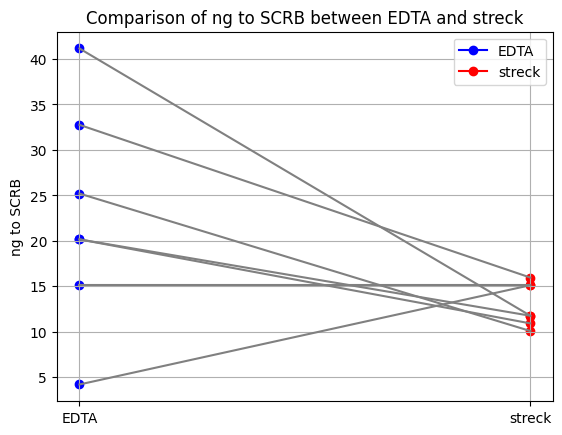

In [ ]:
# Filter the DataFrame to include only EDTA and streck samples
edta_samples = cf_method[cf_method['Tube'] == 'EDTA']
streck_samples = cf_method[cf_method['Tube'] == 'streck']

# Plotting the ng to SCRB values for EDTA samples with corresponding streck samples
for index, edta_row in edta_samples.iterrows():
    streck_row = streck_samples[streck_samples['sample_name'] == edta_row['sample_name']]
    if not streck_row.empty:
        plt.scatter(1, edta_row['ng to SCRB'], color='blue', label='EDTA' if index == 0 else None)
        plt.scatter(2, streck_row.iloc[0]['ng to SCRB'], color='red', label='streck' if index == 0 else None)
        plt.plot([1, 2], [edta_row['ng to SCRB'], streck_row.iloc[0]['ng to SCRB']], color='gray')

# Customize plot
plt.ylabel('ng to SCRB')
plt.xticks([1, 2], ['EDTA', 'streck'])
plt.title('Comparison of ng to SCRB between EDTA and streck')
# Create custom legend entries
blue_patch = plt.Line2D([0], [0], marker='o', color='blue', label='EDTA')
red_patch = plt.Line2D([0], [0], marker='o', color='red', label='streck')
plt.legend(handles=[blue_patch, red_patch])
plt.grid(True)
plt.show()


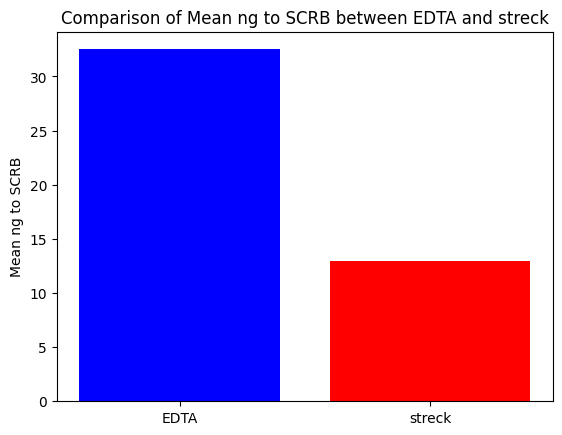

In [ ]:
import matplotlib.pyplot as plt

# Calculate the mean ng to SCRB values for EDTA and streck samples
mean_edta = edta_samples['ng to SCRB'].mean()
mean_streck = streck_samples['ng to SCRB'].mean()

# Plotting the mean values as a bar plot
plt.bar(['EDTA', 'streck'], [mean_edta, mean_streck], color=['blue', 'red'])

# Add labels and title
plt.ylabel('Mean ng to SCRB')
plt.title('Comparison of Mean ng to SCRB between EDTA and streck')

plt.show()
